## LDA Topic Analysis using medium post titles data set from kaggle
##### Dataset can be found at https://www.kaggle.com/nulldata/medium-post-titles

### Imports for use in text preprocessing

In [77]:
# Imports required along with usage
import pprint # Used for displaying information easily
import numpy as np # Numpy for linear algebra
import pandas as pd # Pandas for data manipulation
import seaborn as sns # Plots for visualization
import matplotlib.pyplot as plt # Plots for visualization
# Note need to run `python -m spacy download en` for access to `en_core_web_sm`
import nltk # Stop words list
import pyLDAvis # Interactive topic model visualization
import pyLDAvis.gensim_models # Models from gensim
import gensim # Gensim models for preprocessing and builing model
import gensim.corpora as corpora # Topic model corpus
from gensim.utils import simple_preprocess # Processing text input
from gensim.models import CoherenceModel # Model for data
import spacy # Lemmatization (finding roots)

### Preprocessing of text for use in model

In [ ]:
# Read in data
df = pd.read_csv('medium_post_titles.csv')

# Create column containing title and subtitle concatenated
df['complete_titles'] = df['title'] + ' ' + df['subtitle']
data = list(df.complete_titles)

# Load spacy tagger and stop words from nltk downloaded earlier
nlp = spacy.load('en_core_web_sm', disable=['parser', 'ner'])
stop_words = nltk.corpus.stopwords.words('english')

def process_text(texts, stop_words=stop_words, allowed_tags=['NOUN', 'AJD', 'VERB', 'ADV']):
    """
    Convert text to lowercase tokens,
    build bigrams/trigrams,
    implement lemmatization
    :param text: text to process
    :param stop_words: list of stop words to use
    :param allowed_tags: parts of speech allowed to be used
    :return:
    """
    # Removes stopwords from texts
    texts = [[word for word in simple_preprocess(str(doc), deacc=True, min_len=3) if word not in stop_words] for doc in texts]

    # Implement lemmatization and filter based on allowed tags
    texts_out = []
    for text in texts:
        doc = nlp(" ".join(text))
        texts_out.append([token.lemma_ for token in doc if token.pos_ in allowed_tags])
    # Remove stopwards and short tokens again now that lemmatization is done
    texts_out = [[word for word in simple_preprocess(str(doc), deacc=True, min_len=3) if word not in stop_words] for doc in texts_out]
    return texts_out

data_processed = process_text(data)
# Create dictionary of processed words and report size
id2word = corpora.Dictionary(data_processed)
print('Total Vocabulary Size:', len(id2word))

# Create corpus
corpus = [id2word.doc2bow(text) for text in data_processed]

### Visualizations of data for overview

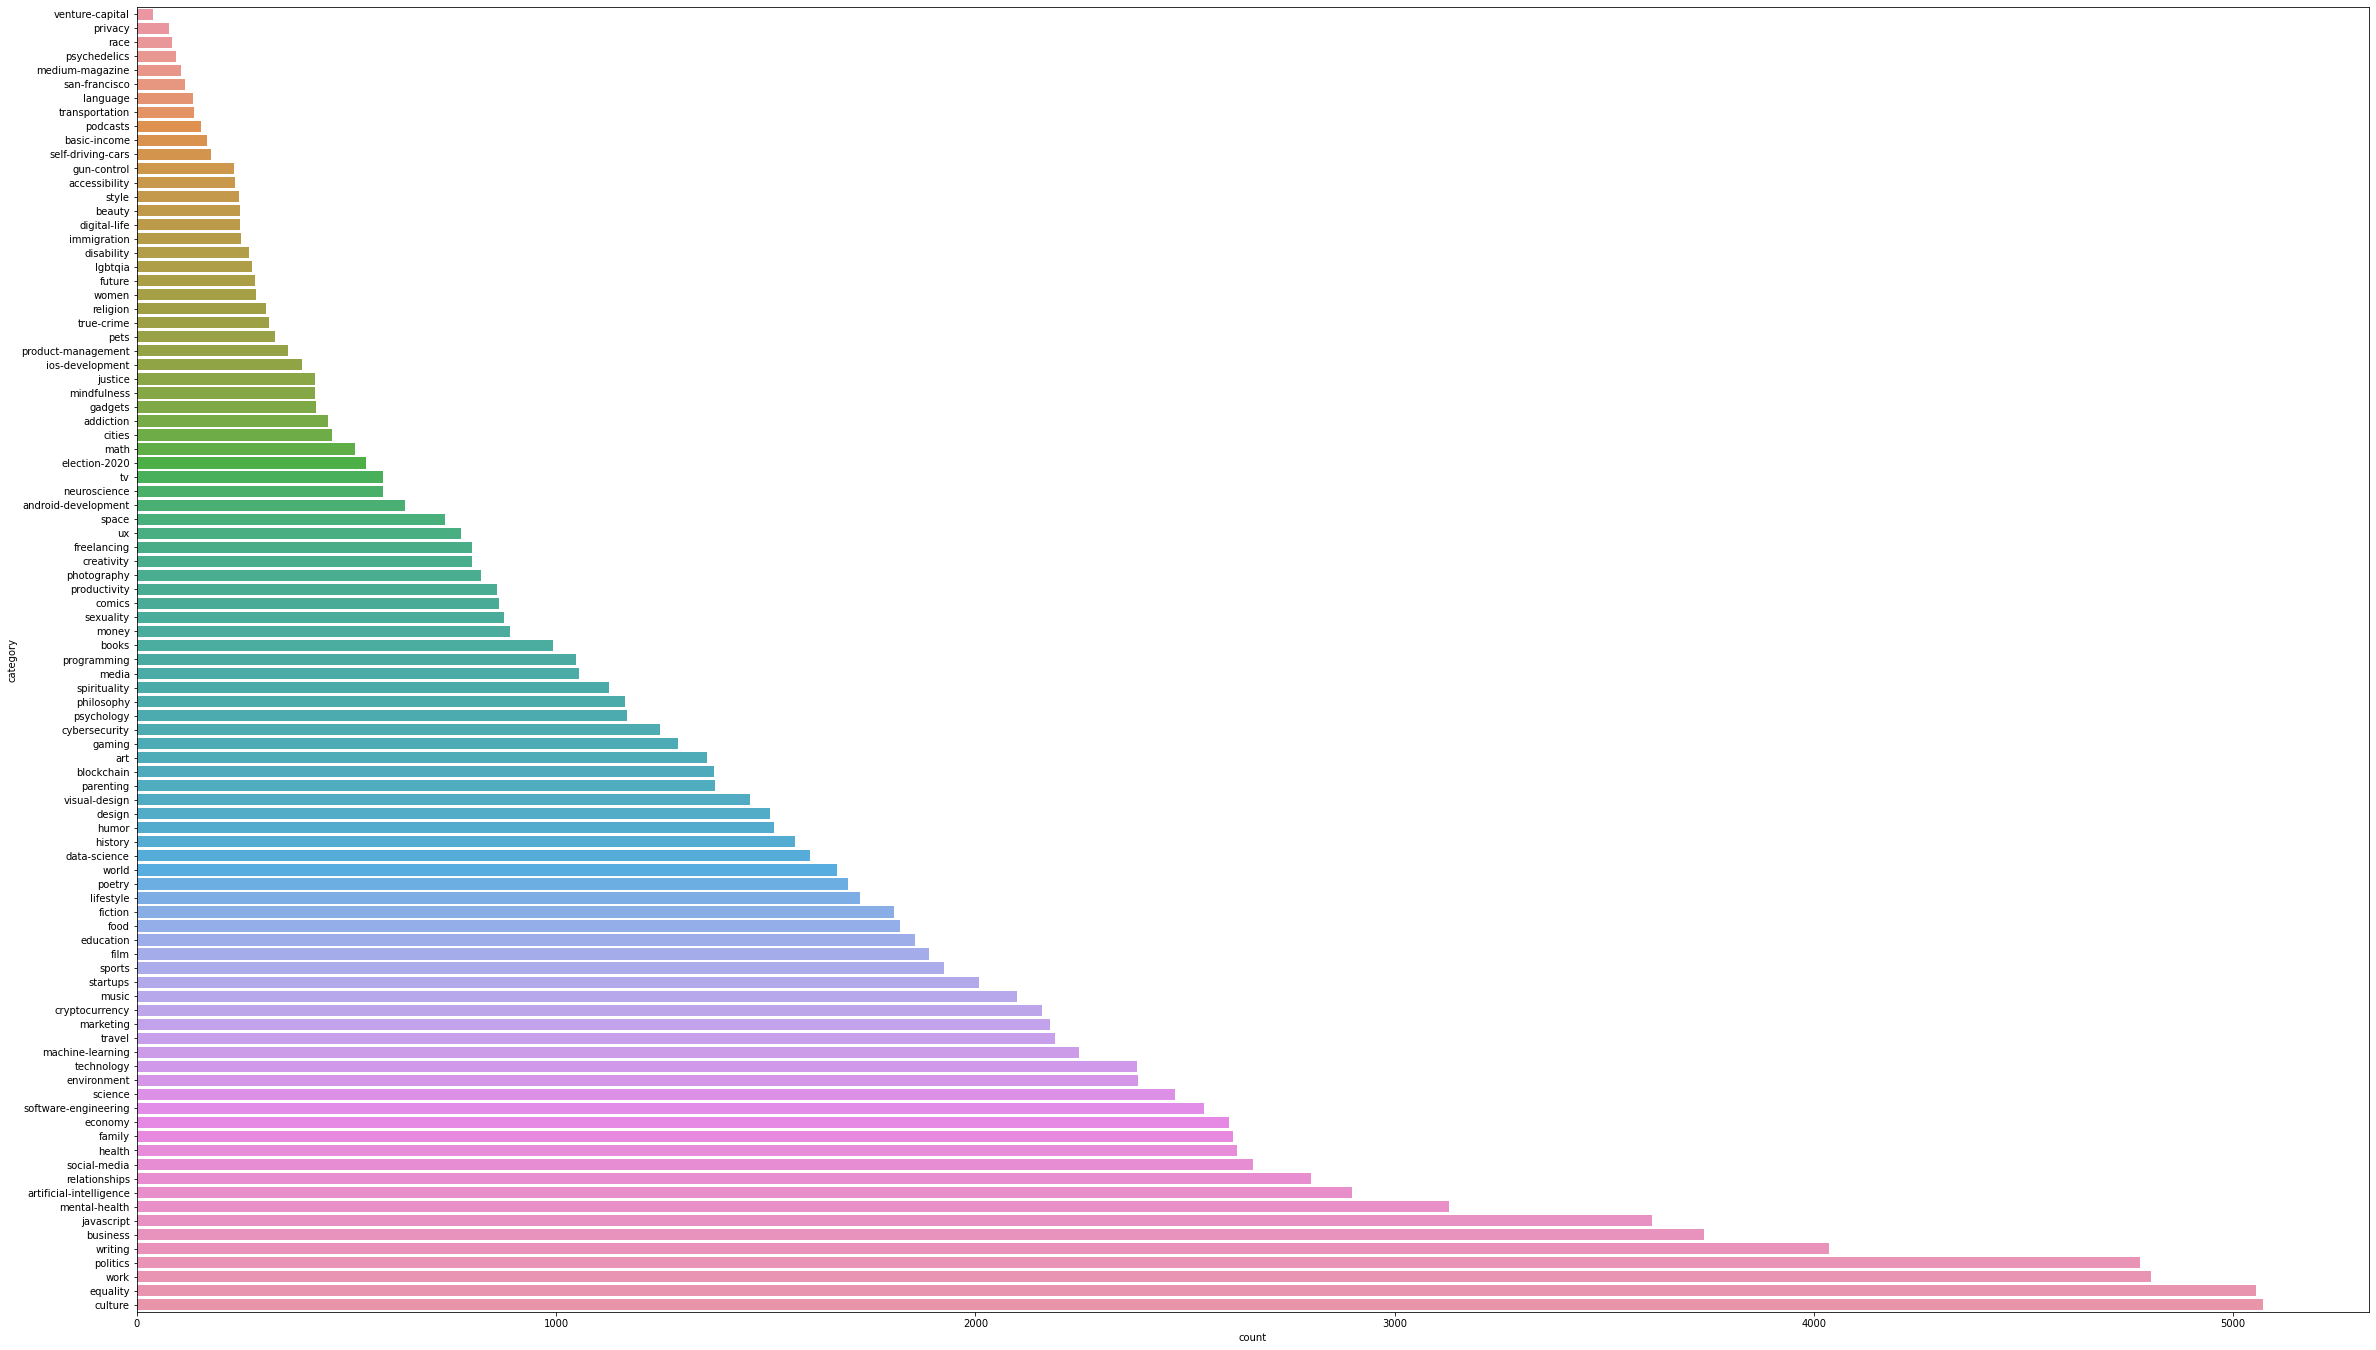

<Figure size 576x432 with 0 Axes>

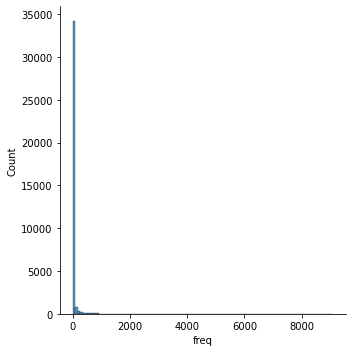

        freq
make    9081
use     7907
year    7593
get     7574
time    7433
work    6221
people  6012
learn   5884
life    5836
need    5307


In [79]:
# Displaying barplot of categories in dataset
ordered_categories = df.category.value_counts(ascending=True).index
plt.figure(figsize=(40, 24))
sns.countplot(y='category', data=df, orient='h', order=ordered_categories)

# Displaying words in corpus
dict_corpus = {}
for i in range(len(corpus)):
    for idx, freq in corpus[i]:
        if id2word[idx] in dict_corpus:
            dict_corpus[id2word[idx]] += freq
        else:
            dict_corpus[id2word[idx]] = freq

dict_df = pd.DataFrame.from_dict(dict_corpus, orient='index', columns=['freq'])
plt.figure(figsize=(8, 6))
sns.displot(dict_df['freq'], bins=100)
plt.show()
print(dict_df.sort_values('freq', ascending=False).head(10))

### More preprocessing of text for corpus

In [80]:
# Find words to add to stop words list
extension = dict_df[dict_df.freq > 1500].index.tolist()
stop_words.extend(extension)
data_processed = process_text(data)
id2word = corpora.Dictionary(data_processed)
print('Total Vocabulary Size:', len(id2word))
# Remove words occurring < 10 docs or > 50% of docs
id2word.filter_extremes(no_below=10, no_above=0.5)
print('Total Vocabulary Size:', len(id2word))

# Final Corpus
corpus = [id2word.doc2bow(text) for text in data_processed]

Total Vocabulary Size: 36380
Total Vocabulary Size: 7221


### Model Creation

In [81]:
# Initialize the model with your corpus for 10 topics
ldamodel = gensim.models.LdaMulticore(corpus, id2word=id2word, num_topics=10)

# Display the 10 topics with words and their weight
pprint.pprint(ldamodel.show_topics(formatted=False))

[(0,
  [('money', 0.009078471),
   ('kid', 0.0078123366),
   ('pay', 0.005805811),
   ('parent', 0.0055653844),
   ('place', 0.005542016),
   ('analysis', 0.0049853097),
   ('long', 0.004664176),
   ('seem', 0.0042396053),
   ('trump', 0.0042290105),
   ('body', 0.003865389)]),
 (1,
  [('goal', 0.005904867),
   ('computer', 0.005686736),
   ('challenge', 0.0053321486),
   ('reality', 0.0050897696),
   ('service', 0.0050643375),
   ('development', 0.0047305515),
   ('space', 0.0043733814),
   ('research', 0.004361734),
   ('brain', 0.00406887),
   ('intelligence', 0.003996783)]),
 (2,
  [('care', 0.0075541986),
   ('climate', 0.005730566),
   ('tool', 0.005380047),
   ('home', 0.004959577),
   ('dream', 0.0046809735),
   ('student', 0.0046426845),
   ('community', 0.004053449),
   ('side', 0.00404778),
   ('intelligence', 0.0039513903),
   ('relationship', 0.0037726834)]),
 (3,
  [('travel', 0.006717742),
   ('sex', 0.0057550003),
   ('face', 0.0045541865),
   ('note', 0.00427335),
   (

### Calculate Model Coherence Score

In [82]:
coherence_model_lda = CoherenceModel(model=ldamodel, texts=data_processed, dictionary=id2word, coherence='c_v')
coherence_score = coherence_model_lda.get_coherence()
print('Coherence Score: %s' % coherence_score)

Coherence Score: 0.17688759004603408


### Display topics frequent words

In [83]:
tm_results = ldamodel[corpus]
corpus_topics = [sorted(topics, key=lambda record: record[-1])[0] for topics in tm_results]
# Columns
topics = [[(term, round(wt, 3)) for term, wt in ldamodel.show_topic(n, topn=20)] for n in range(0, ldamodel.num_topics)]
topics_df = pd.DataFrame([[term for term, wt in topic] for topic in topics], columns= ['Term' + str(i) for i in range(1, 21)], index=['Topic ' + str(t) for t in range(1, ldamodel.num_topics + 1)]).T
topics_df.head()

,Topic 1,Topic 2,Topic 3,Topic 4,Topic 5,Topic 6,Topic 7,Topic 8,Topic 9,Topic 10
Term1,money,goal,care,travel,web,first,javascript,react,lead,software
Term2,kid,computer,climate,sex,market,family,bitcoin,lesson,marketing,friend
Term3,pay,challenge,tool,face,news,city,interview,speak,lie,lose
Term4,parent,reality,home,note,remember,anxiety,person,move,break,music
Term5,place,service,dream,first,framework,eat,facebook,hear,reason,value


In [ ]:
# Rows
pd.set_option('display.max_colwidth', -1)
topics_df = pd.DataFrame([', '.join([term for term, wt in topic]) for topic in topics], columns = ['Terms per Topic'], index=['Topic'+str(t) for t in range(1, ldamodel.num_topics+1)] )
topics_df

### Display topics clustering

In [ ]:
vis = pyLDAvis.gensim_models.prepare(ldamodel, corpus, id2word, sort_topics=False)
pyLDAvis.display(vis)

### Get Dominant Topic Counts from Corpus

In [86]:
corpus_topic_df = pd.DataFrame()
corpus_topic_df['Title'] = df.title
corpus_topic_df['Dominant Topic'] = [item[0] + 1 for item in corpus_topics]
corpus_topic_df['Contribution %'] = [round(item[1] * 100, 2) for item in corpus_topics]
corpus_topic_df['Topic Terms'] = [topics_df.iloc[t[0]]['Terms per Topic'] for t in corpus_topics]

dominant_topic_df = corpus_topic_df.groupby('Dominant Topic').agg(
    Doc_Count = ('Dominant Topic', np.size),
    Total_Docs_Perc = ('Dominant Topic', np.size)).reset_index()

dominant_topic_df['Total_Docs_Perc'] = dominant_topic_df['Total_Docs_Perc'].apply(lambda row: round((row * 100) / len(corpus), 2))
dominant_topic_df

,Dominant Topic,Doc_Count,Total_Docs_Perc
0,1,16444,13.01
1,2,12109,9.58
2,3,12950,10.24
3,4,13314,10.53
4,5,12464,9.86
5,6,11579,9.16
6,7,12860,10.17
7,8,11457,9.06
8,9,10028,7.93
9,10,13213,10.45


### Function to gather coherence scores for different numbers of topics

In [87]:
from tqdm import tqdm # Used to show progress meter
import os # Used to access filesystem and environment variables
import config # Used to store secrets for easy access within Jupyter Notebook

path = config.path

# Cache to store previously calculated models and scores
cache = pickle.load(open(path, 'rb')) if os.path.exists(path) else dict()
def topic_model_coherence_scores(corpus, texts, dictionary, start_topic_count=2, end_topic_count=10, step=1, cpus=1):
    models = []
    coherence_scores = []
    for topic_nums in tqdm(range(start_topic_count, end_topic_count+1, step)):
        # If topic number has been calculated get its value from cache
        if topic_nums in cache:
            models.append(cache[topic_nums][0])
            coherence_scores.append(cache[topic_nums][1])
            continue
        # Otherwise calculate then store in cache
        model = gensim.models.LdaMulticore(corpus, id2word=id2word, num_topics=topic_nums, iterations=500, workers=cpus)

        cv_coherence_model_lda = gensim.models.CoherenceModel (model=model, corpus=corpus, texts=texts,
                                                                     dictionary=dictionary, coherence='c_v')
        coherence_score = cv_coherence_model_lda.get_coherence()
        coherence_scores.append(coherence_score)
        models.append(model)
        cache[topic_nums] = (model, coherence_score)
    return models, coherence_scores

### Gather coherence scores and plot results

100%|██████████| 31/31 [00:00<00:00, 150490.07it/s]


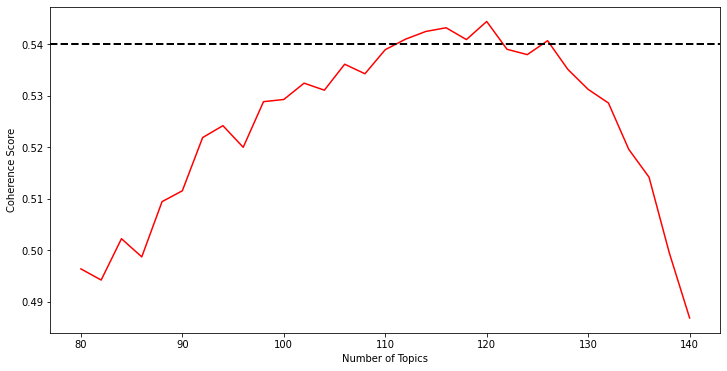

In [88]:
# Gather models and scores
models, scores = topic_model_coherence_scores(corpus=corpus, texts=data_processed, dictionary=id2word, start_topic_count=80, end_topic_count=140, step=2, cpus=2)

# Plot the results
x_ax = range(80, 141, 2)
y_ax = scores
plt.figure(figsize=(12, 6))
plt.plot(x_ax, y_ax, c='r')
plt.axhline(y=0.54, c='k', linestyle='--', linewidth=2)
plt.rcParams['figure.facecolor'] = 'white'
xl = plt.xlabel('Number of Topics')
yl = plt.ylabel('Coherence Score')
plt.show()

### Pickle cache from plot for other tests

In [89]:
pickle.dump(cache, open('/Users/masonhorne/PycharmProjects/TopicModeling/modelcache.pkl', 'wb+'))

### Results

Looking at the plot of number topics to coherence score. We can see that the ideal number of topics to use for this dataset will be somewhere between **110** to **125** topics. This range is where our Coherence score reaches its highest points above .54.

These are much better than the previously calculated Coherence Score from our model of 10 topics. Which we did our initial investigation on which resulted in a score of less than half of this **(0.19)**.

With further investigation we can use the previous visualization techniques and keyword occurrences to give each topic their own name. Allowing for the initial documents to be categorized based on these overall topic names.



##### References
###### https://medium.com/@kurtsenol21/topic-modeling-lda-mallet-implementation-in-python-part-1-c493a5297ad2
###### https://radimrehurek.com/gensim/auto_examples/index.html
###### https://matplotlib.org/3.5.1/api/index.html